In [1]:
# analysis of the Carlini-Wagner and PGD attacks on SPEECHCOMMANDS

In [2]:
%load_ext autoreload
%autoreload 2
# Disable jedi autocompleter
%config Completer.use_jedi = False

In [3]:
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
# import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [4]:
# import matplotlib as mpl
# # set this 'backend' when using jupyter; do this before importing pyplot
# mpl.use('nbagg')
%matplotlib notebook
import matplotlib.pyplot as plt
# mpl.rcParams['figure.figsize'] = (8.0, 6.0)

In [5]:
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [6]:
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# manually set cuda device
torch.cuda.set_device(1)
device = 'cpu'
print(device)

cpu


/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:125: UserWarning: 
NVIDIA GeForce RTX 2080 Ti with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 2080 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [8]:
### 0 - prelims
# load all the models
## classic model
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2).squeeze()
    
# FGN model    
class FGN_M5(nn.Module):
    
    # changes:
    # nn.Conv1d -> fgnl.FGN_Conv1d
    # added g to conv inputs and outputs
    # make sure you pass g through the same pooling steps as x
    
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.fgn_conv1 = fgnl.FGN_Conv1d(in_channels=n_input, out_channels=n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.fgn_conv2 = fgnl.FGN_Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.fgn_conv3 = fgnl.FGN_Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.fgn_conv4 = fgnl.FGN_Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        
    def forward(self, x):
        x, g = self.fgn_conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        g = self.pool1(g)
        x, g = self.fgn_conv2(x, g)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        g = self.pool2(g)
        x, g = self.fgn_conv3(x ,g)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        g = self.pool3(g)
        x, _ = self.fgn_conv4(x, g)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2).squeeze()


# pretrained models paths
save_path = '/home/felix/Research/Adversarial Research/FGN---Research/Experiments/sample_SPEECHCOMMANDS_models/'

classic_model_name= 'sample_classic_model_SPEECHCOMMANDS'
fgn_model_name = 'sample_FGN_model_SPEECHCOMMANDS'


# define and load the models
# classic model
classic_model = M5()
classic_model.load_state_dict(torch.load(save_path+classic_model_name+'_state_dict.pth'))
# classic_model.to(device)

# fgn model trained from scratch
fgn_model_from_scratch = FGN_M5()
fgn_model_from_scratch.load_state_dict(torch.load(save_path+fgn_model_name+'_state_dict.pth'))
fgn_model_from_scratch.to(device)

# converted fgn model (no retraining)
fgn_model_converted_no_retraining = FGN_M5()
fgn_model_converted_no_retraining.load_state_dict(torch.load(save_path+'sample_FGN_converted_model_SPEECHCOMMANDS'+'_state_dict.pth'))
# fgn_model_converted_no_retraining.to(device)

# converted and retrained 1 epoch fgn model
fgn_model_converted_fast_retraining = FGN_M5()
fgn_model_converted_fast_retraining.load_state_dict(torch.load(save_path+'sample_FGN_converted_fast_retrained_model_SPEECHCOMMANDS'+'_state_dict.pth'))
# fgn_model_converted_fast_retraining.to(device)

# converted and retrained 21 epoch fgn model
fgn_model_converted_long_retraining = FGN_M5()
fgn_model_converted_long_retraining.load_state_dict(torch.load(save_path+'sample_FGN_converted_long_retrained_model_SPEECHCOMMANDS'+'_state_dict.pth'))
# fgn_model_converted_long_retraining.to(device)


# set all models to eval mode
classic_model.eval()
fgn_model_from_scratch.eval()
fgn_model_converted_no_retraining.eval()
fgn_model_converted_fast_retraining.eval()
fgn_model_converted_long_retraining.eval()

FGN_M5(
  (fgn_conv1): FGN_Conv1d(
    (Conv1d): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  )
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv2): FGN_Conv1d(
    (Conv1d): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  )
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv3): FGN_Conv1d(
    (Conv1d): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  )
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv4): FGN_Conv1d(
    (Conv1d): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  )
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): Ma

In [9]:
model_name_pairs = {'Classic': classic_model,
                    'FGN_from_scratch': fgn_model_from_scratch,
                    'FGN_converted (no retraining)': fgn_model_converted_no_retraining,
                    'FGN_converted (fast retraining)': fgn_model_converted_fast_retraining,
                    'FGN_converted (long retraining)': fgn_model_converted_long_retraining
                   }

In [10]:
### 1 - Verify location of attacks
# attack_results_dir = '/scratch/felix/FGN---Results/adversarial_attacks_results/1637192331.3530319/' # 0_24, prob old
# attack_results_dir = '/scratch/felix/FGN---Results/adversarial_attacks_results/1637192253.3900166/' # contains nothing
# attack_results_dir = '/scratch/felix/FGN---Results/adversarial_attacks_results/1633722950.2487264/' # prob old
# attack_results_dir = '/scratch/felix/FGN---Results/adversarial_attacks_results/1633715707.3646119/' # prob old
# attack_results_dir = '/scratch/felix/FGN---Results/1637192253.3900166/' # 0 files

attack_results_dir_0_24 = '/scratch/felix/FGN---Results/1637192331.3530319/'
# start_0_stop_24

attack_results_dir_24_48 = '/scratch/felix/FGN---Results/1637433413.7582006/'
# start_24_stop_48

attack_results_dir_48_none = '/scratch/felix/FGN---Results/1637624970.2306073/'
# start_48_stop_none 

In [11]:
attack_results_dir_list_0_24 = sorted(glob.glob(attack_results_dir_0_24+'/*', recursive = True))
attack_results_dir_list_24_48 = sorted(glob.glob(attack_results_dir_24_48+'/*', recursive = True))
attack_results_dir_list_48_none = sorted(glob.glob(attack_results_dir_48_none+'/*', recursive = True))

In [12]:
all_attack_results = attack_results_dir_list_0_24 + attack_results_dir_list_24_48 + attack_results_dir_list_48_none

In [13]:
len(sorted(all_attack_results))
# should be
# 2 attacks * 5 models * 3 batches * 3 types(clipped raw success)= 90

90

In [14]:
for l in sorted(all_attack_results):
    print(l)

/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_classic_f_model_adv_clipped_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_classic_f_model_adv_raw_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_classic_f_model_adv_success_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_fast_retraining_adv_clipped_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_fast_retraining_adv_raw_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_fast_retraining_adv_success_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_long_retraining_adv_clipped_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_long_retraining_adv_raw_start

In [17]:
attacks_name = ['L2CarliniWagner', 'LinfPGD']
model_name_to_path_name = {'Classic': 'classic_f_model',
                           'FGN_from_scratch': 'fgn_f_model_from_scratch',
                           'FGN_converted (no retraining)': 'fgn_f_model_converted_no_retraining',
                           'FGN_converted (fast retraining)': 'fgn_f_model_converted_fast_retraining',
                           'FGN_converted (long retraining)': 'fgn_f_model_converted_long_retraining'
                          }


In [18]:
### load SPEECHCOMMANDS data

labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

# load dataset
batch_size = 32
batchsize_for_val = 128
resample_rate = 8000
(train_loader, val_loader, test_loader) = fgnh.SpeechCommands_Dataloaders(resample_rate = resample_rate,
                                                                          batch_size = batch_size,
                                                                          batchsize_for_val = batchsize_for_val,
                                                                          num_workers=5, 
                                                                          pin_memory=True)
# associate the right batch of adv results with the right samples
#     number of samples in the first batch: (18, 3072, 1, 8000)
#     number of samples in the second batch: (18, 3072, 1, 8000)
#     number of samples in the third batch: (18, 3837, 1, 8000)
#     total number of samples: 9981

# (batch_name, start_id, end_idx)
batch_names_indices_pairs = [('start_0_stop_24', 0, 3071),
                             ('start_24_stop_48', 3072, 6143), 
                             ('start_48_stop_None', 6144, 9980)]

In [24]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

84843
9981
11005


In [17]:
import IPython.display as ipd

In [60]:
# show some audio sample

# sample index
idx = 9980
val_set = val_loader.dataset # note these are not resampled
print('number of samples:', len(val_set))
waveform, sample_rate, label, speaker_id, utterance_number = val_set[idx]

from torchaudio import transforms
transform = transforms.Resample(orig_freq=sample_rate, new_freq=resample_rate)

number of samples: 9981


Shape of original waveform: torch.Size([1, 16000])
Sample rate of origwaveform: 16000


<IPython.core.display.Javascript object>


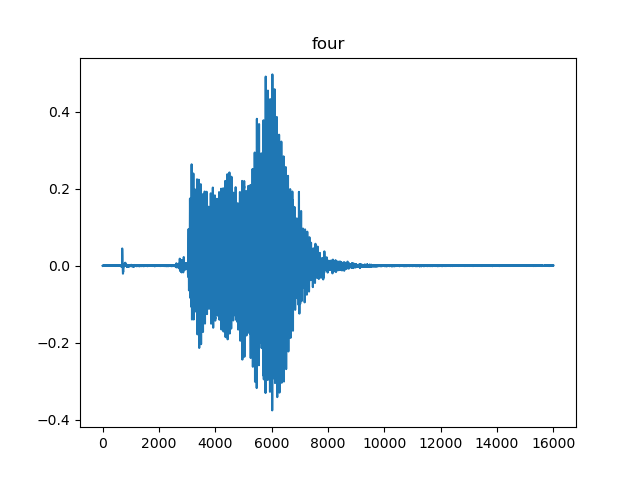

Label: four


In [61]:
print("Shape of original waveform: {}".format(waveform.size()))
print("Sample rate of origwaveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())
plt.title(label)
plt.show()

print('Label:',label)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Shape of resampled waveform: torch.Size([1, 8000])


<IPython.core.display.Javascript object>


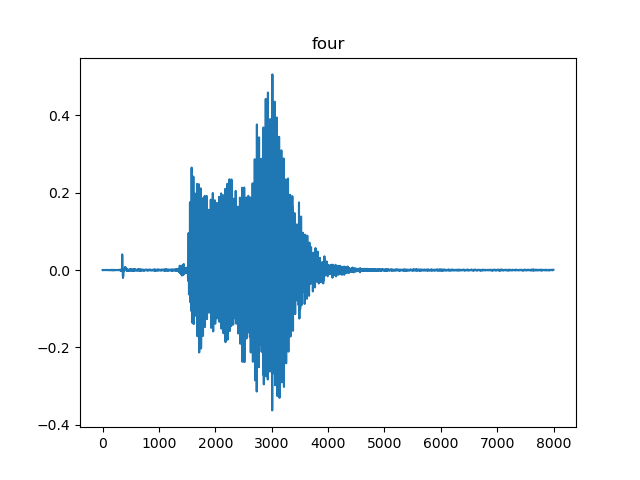

Label: four


In [62]:
# the actual resampled waveform passed to the neural network
waveform_resampled = transform(waveform)
print("Shape of resampled waveform: {}".format(waveform_resampled.size()))

plt.plot(waveform_resampled.t().numpy())
plt.title(label)
plt.show()

print('Label:',label)
ipd.Audio(waveform_resampled.numpy(), rate=resample_rate)

In [63]:
# load some results

In [64]:
import pickle

In [65]:
# load some results
# get a sample audio and label
# play adversarial audio and show prediction

In [71]:
# type of results to look at
attack_name = 'L2CarliniWagner'
model_name = 'classic_f_model'
model = classic_model

# load the right batch based on index
#     number of samples in the first batch: (18, 3072, 1, 8000)
#     number of samples in the second batch: (18, 3072, 1, 8000)
#     number of samples in the third batch: (18, 3837, 1, 8000)
#     total number of samples: 9981

if idx<3072:
    batch_name = 'start_0_stop_24'
    batch_idx = idx
elif idx>=3072 and idx<3072*2:
    batch_name = 'start_24_stop_48'
    batch_idx = idx-3072
else:
    batch_name = 'start_48_stop_None'
    batch_idx = idx-3072*2


# paths to load
paths_to_load = [p for p in all_attack_results 
                 if (attack_name in p 
                     and model_name in p
                     and batch_name in p)]

In [72]:
paths_to_load

['/scratch/felix/FGN---Results/1637624970.2306073/L2CarliniWagner_classic_f_model_adv_clipped_start_48_stop_None.pickle',
 '/scratch/felix/FGN---Results/1637624970.2306073/L2CarliniWagner_classic_f_model_adv_raw_start_48_stop_None.pickle',
 '/scratch/felix/FGN---Results/1637624970.2306073/L2CarliniWagner_classic_f_model_adv_success_start_48_stop_None.pickle']

In [73]:
# load the two pickles we care about
for p in paths_to_load:
    if 'adv_raw' in p:
        print('loading:', p)
        with open(p, 'rb') as f:
            results_adv_raw = pickle.load(f)
    if 'adv_success' in p:
        print('loading:', p)
        with open(p, 'rb') as f:
            results_adv_success = pickle.load(f)

loading: /scratch/felix/FGN---Results/1637624970.2306073/L2CarliniWagner_classic_f_model_adv_raw_start_48_stop_None.pickle
loading: /scratch/felix/FGN---Results/1637624970.2306073/L2CarliniWagner_classic_f_model_adv_success_start_48_stop_None.pickle


In [93]:
for eps in range(18):
    print(sum(results_adv_success[eps]))

442.0
1184.0
1471.0
1718.0
2003.0
2214.0
2579.0
2829.0
3164.0
3425.0
3670.0
3735.0
3785.0
3808.0
3833.0
3837.0
3837.0
3837.0


In [97]:
quick_counts = {'L2CarliniWagner':{'classic_f_model':[0 for _ in range(18)], 
                                  'fgn_f_model_converted_fast_retraining':[0 for _ in range(18)],
                                  'fgn_f_model_converted_long_retraining':[0 for _ in range(18)],
                                  'fgn_f_model_converted_no_retraining':[0 for _ in range(18)],
                                  'fgn_f_model_from_scratch':[0 for _ in range(18)],
                                  },
                'LinfPGD':{'classic_f_model':[0 for _ in range(18)], 
                           'fgn_f_model_converted_fast_retraining':[0 for _ in range(18)],
                           'fgn_f_model_converted_long_retraining':[0 for _ in range(18)],
                           'fgn_f_model_converted_no_retraining':[0 for _ in range(18)],
                           'fgn_f_model_from_scratch':[0 for _ in range(18)],
                          },
               }
for p in all_attack_results:
    # open successes
    if 'adv_success' in p:
        print('loading:', p)
        with open(p, 'rb') as f:
            results_adv_success = pickle.load(f)
        
        # get model and attack name
        if 'L2CarliniWagner' in p:
            attack_name = 'L2CarliniWagner'
        elif 'LinfPGD' in p:
            attack_name = 'LinfPGD'
        
        if 'classic_f_model' in p:
            model_name = 'classic_f_model'
        elif 'fgn_f_model_converted_fast_retraining' in p:
            model_name = 'fgn_f_model_converted_fast_retraining'
        elif 'fgn_f_model_converted_long_retraining' in p:
            model_name = 'fgn_f_model_converted_long_retraining'
        elif 'fgn_f_model_converted_no_retraining' in p:
            model_name = 'fgn_f_model_converted_no_retraining'
        elif 'fgn_f_model_from_scratch' in p:
            model_name = 'fgn_f_model_from_scratch'
            
        # add up per epsilon
        for eps in range(18):
            quick_counts[attack_name][model_name][eps] += sum(results_adv_success[eps])

loading: /scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_classic_f_model_adv_success_start_0_stop_24.pickle
loading: /scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_fast_retraining_adv_success_start_0_stop_24.pickle
loading: /scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_long_retraining_adv_success_start_0_stop_24.pickle
loading: /scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_no_retraining_adv_success_start_0_stop_24.pickle
loading: /scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_from_scratch_adv_success_start_0_stop_24.pickle
loading: /scratch/felix/FGN---Results/1637192331.3530319/LinfPGD_classic_f_model_adv_success_start_0_stop_24.pickle
loading: /scratch/felix/FGN---Results/1637192331.3530319/LinfPGD_fgn_f_model_converted_fast_retraining_adv_success_start_0_stop_24.pickle
loading: /scratch/felix/FGN---Results/1637192331.3530

In [99]:
print(quick_counts)

{'L2CarliniWagner': {'classic_f_model': [1226.0, 3162.0, 3936.0, 4551.0, 5313.0, 5889.0, 6830.0, 7505.0, 8342.0, 8973.0, 9518.0, 9678.0, 9803.0, 9871.0, 9960.0, 9981.0, 9981.0, 9981.0], 'fgn_f_model_converted_fast_retraining': [1241.0, 2856.0, 3539.0, 4174.0, 5020.0, 5580.0, 6507.0, 7080.0, 7790.0, 8336.0, 8800.0, 8956.0, 9067.0, 9127.0, 9205.0, 9216.0, 9216.0, 9216.0], 'fgn_f_model_converted_long_retraining': [1255.0, 3403.0, 4249.0, 4913.0, 5700.0, 6251.0, 7148.0, 7767.0, 8640.0, 9374.0, 9752.0, 9829.0, 9905.0, 9929.0, 9972.0, 9981.0, 9981.0, 9981.0], 'fgn_f_model_converted_no_retraining': [1176.0, 3015.0, 3762.0, 4341.0, 5060.0, 5609.0, 6487.0, 7121.0, 7914.0, 8515.0, 9038.0, 9182.0, 9303.0, 9367.0, 9451.0, 9472.0, 9472.0, 9472.0], 'fgn_f_model_from_scratch': [1409.0, 3629.0, 4371.0, 5007.0, 5820.0, 6317.0, 7127.0, 7732.0, 8617.0, 9103.0, 9517.0, 9645.0, 9773.0, 9842.0, 9962.0, 9981.0, 9981.0, 9981.0]}, 'LinfPGD': {'classic_f_model': [1064.0, 8832.0, 8832.0, 8832.0, 8832.0, 8832.0, 

In [74]:
# look at the adversarial waveform
# there are 18 espilons tested
epsilon_idx = 17
adv_waveform = results_adv_raw[epsilon_idx][batch_idx]

<IPython.core.display.Javascript object>


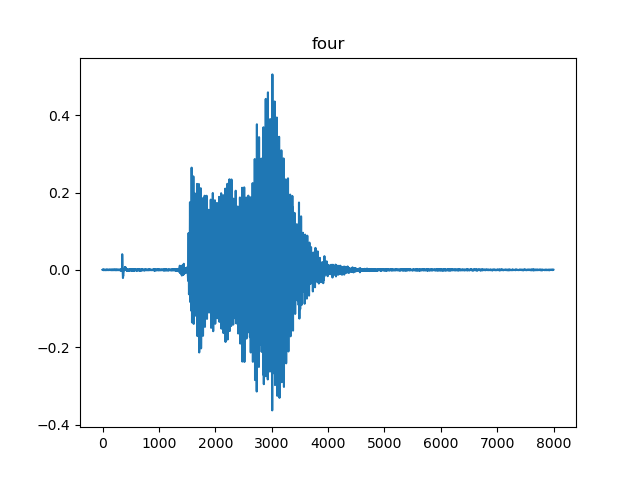

Label: four


In [75]:
plt.plot(adv_waveform.T)
plt.title(label)
plt.show()

print('Label:',label)
ipd.Audio(adv_waveform, rate=resample_rate)

In [77]:
# verify difference in values
waveform_resampled.numpy()

array([[-3.1064370e-05,  7.2092887e-05,  2.5033469e-06, ...,
        -7.1230053e-05, -8.3514178e-06,  5.7997974e-04]], dtype=float32)

In [78]:
waveform_resampled.numpy().reshape(-1) - adv_waveform.reshape(-1)

array([-2.43187755e-04,  2.46833682e-04, -2.46028231e-04, ...,
        3.31783667e-09,  3.70982889e-09,  3.72529030e-09])

In [79]:
# what was the outcome of the attack?
# 1.0 = successful attack
results_adv_success[epsilon_idx][batch_idx]

1.0

In [81]:
# verify by running the model on the adversarial sample
output = model(torch.tensor(adv_waveform).to(device).unsqueeze(0).float()).cpu().detach().numpy()

In [82]:
output

array([-11.854972  , -17.474916  , -11.735737  , -14.250216  ,
       -18.813223  , -18.493168  , -26.708515  , -10.056961  ,
       -11.975247  ,  -6.2200203 ,  -0.81257176, -20.364742  ,
       -23.17622   , -22.99187   ,  -4.3429384 ,  -0.620579  ,
        -9.799572  , -13.926408  , -16.503283  , -13.1844845 ,
       -12.576147  ,  -5.678343  , -12.033764  , -15.295286  ,
       -10.902535  , -16.518915  , -18.155497  , -21.963379  ,
       -28.41904   , -21.780815  , -18.584896  , -15.63964   ,
        -9.297411  , -13.80237   , -14.601117  ], dtype=float32)

In [83]:
pred = np.argmax(output)
pred

15

In [84]:
# softmax value
softmax_output =  np.array([np.exp(x)/sum(np.exp(output)) for x in output])
np.round(softmax_output,decimals=2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.44,
       0.  , 0.  , 0.  , 0.01, 0.54, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  ])

In [91]:
labels[17]

'nine'

In [86]:
# compared to original prediction
output = model(waveform_resampled.to(device).unsqueeze(0)).cpu().detach().numpy()

In [87]:
pred = np.argmax(output)
pred

10

In [88]:
# softmax value
softmax_output =  np.array([np.exp(x)/sum(np.exp(output)) for x in output])
np.round(softmax_output,decimals=2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99,
       0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  ])

In [92]:
labels[10]

'four'

In [41]:
### evaluation of models over all the data 
### and plotting the results

In [55]:
# list of parameters
batch_names_indices_pairs = [('start_0_stop_24', 0, 3071), ('start_24_stop_48', 3072, 6143)]
print(attacks_name)
print(model_name_pairs.keys())
print(batch_names_indices_pairs)
print(save_path)

['L2CarliniWagner', 'LinfPGD']
dict_keys(['Classic', 'FGN_from_scratch', 'FGN_converted (no retraining)', 'FGN_converted (fast retraining)', 'FGN_converted (long retraining)'])
[('start_0_stop_24', 0, 3071), ('start_24_stop_48', 3072, 6143)]
/home/felix/Research/Adversarial Research/FGN---Research/Experiments/sample_SPEECHCOMMANDS_models/


In [43]:
# dev - inside->out
# dev of functions to compute thenumber of advs preds that are successful with over 0.5 softmax
# successful means changes a correct pred into an incorrect one (so not valid on already wrong preds)

# final product: count = {attack: {model_name:[counts_eps1, count_eps2 ... ]}}


def softmax(arr):
    # softmaxes an array
    return np.array([np.exp(x)/sum(np.exp(arr)) for x in arr])

def eval_batch(batch, model, device='cuda', dtype=torch.float, free_gpu_memory=False):
    # evals a model on a batch of data while sending it to the right device and type
    # send data and model to device
    batch_tensor = batch.clone().to(torch.float).to(device)
    model.to(device)
    with torch.no_grad():
        eval_outputs = model(batch_tensor)
    
    results = eval_outputs.cpu().detach().numpy()
    
    # free free_gpu_memory
    if free_gpu_memory:
        model.to('cpu')
        del(batch_tensor)
        del(eval_outputs)
        torch.cuda.empty_cache()
    # return results
    return(results)

def get_pred_confidences(eval_outputs):
    # apply softmax to each output of eval_batch
    softmax_outputs = [softmax(o) for o in eval_outputs]
    # get the arg max index
    pred_indexes = [np.argmax(s) for s in softmax_outputs]
    # what label is that?
    pred_labels = [labels[p] for p in pred_indexes]
    # what the confidence of that pred?
    pred_confs = [softmax_outputs[i][p] for i,p in enumerate(pred_indexes)]
    
    # return as list of dict
    return([{'pred_label':l, 'pred_conf':c} for l,c in zip(pred_labels, pred_confs)] )

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def prep_batch_from_dataset(dataset, start_idx, end_idx):
    # preps the samples from the dataset from start to end 
    # returns a numpy array ready to be evaluated
    # and a list of true labels associated
    # transform should take care of amaking all the same length
    
    batch, true_labels = [], []
    for i in range(start_idx, end_idx+1):
        waveform, _, true_label, _, _ = dataset[i]
        batch.append(transform(waveform))
        true_labels.append(true_label)
    
    batch = pad_sequence(batch)
    
    return(batch, true_labels)
    

def associate_orig_results_with_adv(true_labels, orig_pred_confidences, adv_pred_confidences):
    # associate the true labels to the preds of model on original and adv samples
    # [{true_label:, orig_pred:, orig_conf:, adv_pred:, adv_conf: }]
    assert(len(true_labels)==len(orig_pred_confidences)==len(adv_pred_confidences))
    results = []
    for true_label, orig_pred_conf, adv_pred_conf in zip(true_labels, orig_pred_confidences, adv_pred_confidences):
        results.append({'true_label':true_label,
                        'orig_pred_label':orig_pred_conf['pred_label'], 
                        'orig_pred_conf':orig_pred_conf['pred_conf'], 
                        'adv_pred_label':adv_pred_conf['pred_label'],
                        'adv_pred_conf': adv_pred_conf['pred_conf']}
                      )
        
    return(results)

def was_attack_successful(pred_dict):
    # checks if an attack was a success
    # ie: it changed the class from right to wrong AND both confidences are over 0.5
    # "the attack managed to change a successful prediction into a wrong one"
    if (pred_dict['true_label']==pred_dict['orig_pred_label']) and \
        (pred_dict['orig_pred_conf']>=0.5) and \
        (pred_dict['orig_pred_label']!=pred_dict['adv_pred_label']) and \
        (pred_dict['adv_pred_conf']>=0.5):
        
        return(True)
    else:
        return(False)

# def update_successful_attack_count(count_dict, results_dict, model_name):
    # given dicts of of form:
    # [{true_label:, orig_pred:, orig_conf:, adv_pred:, adv_conf: }]
    # count_dict = {attack: {model_name:[counts_eps1, count_eps2 ... ]}}

In [58]:
# final product: counts = {attack: {model_name:[counts_eps1, count_eps2 ... ]}}

# current counts
# counts = {'L2CarliniWagner': {'Classic': [0, 763, 1238, 1634, 2140, 2581, 3288, 3820, 4529, 5098, 5577, 5715, 5813, 5857, 5905, 5918, 5918, 5918], 
#                               'FGN_from_scratch': [0, 774, 1144, 1500, 1959, 2273, 2814, 3249, 3910, 4296, 4621, 4725, 4803, 4849, 4915, 4931, 4931, 4931], 
#                              }
#          }
already_computed = []

counts = {}

# for each attack
for attack_name in attacks_name:
    # create attack entry
    if attack_name not in counts.keys():
        counts[attack_name] = {}
    # for each model
    for model_name, model in  model_name_pairs.items():
        
        # skips counts already computed
        if (attack_name, model_name) in already_computed:
            print('skipping', attack_name, model_name)
            
        else:
            #create model entry for each epsilon
            counts[attack_name][model_name] = [0 for _ in range(18)]
            # for each batch
            for (batch_name, start_idx, end_idx) in batch_names_indices_pairs:
                print('working on', attack_name, model_name, batch_name)

                # load the right data batch
                paths_to_load = [p for p in all_attack_results 
                                 if attack_name in p
                                 and model_name_to_path_name[model_name] in p
                                 and batch_name in p]

                # pickle files
                # NOTE: some of these are empty so we'll make do
                for p in paths_to_load:
#                     # try loading adv_clipped
#                     try:
#                         if 'adv_clipped' in p:
#                             print('loading:', p)
#                             with open(p, 'rb') as f:
#                                 results_adv_clipped = pickle.load(f)
#                             results_to_use = results_adv_clipped
#                     except:
                    if 'adv_raw' in p:
                        print('loading:', p)
                        with open(p, 'rb') as f:
                            results_adv_raw = pickle.load(f)
                        results_to_use = results_adv_raw
                    # no need to load this
    #                 if 'adv_success' in p:
    #                     print('loading:', p)
    #                     with open(p, 'rb') as f:
    #                         results_adv_success = pickle.load(f)

                # prep val set data
                print('preping original data', start_idx, end_idx)
                orig_samples, true_labels = prep_batch_from_dataset(val_set, start_idx, end_idx)

                # eval samples by sub-batches, biggest data batch having 3837 samples
                step_size = 1000
                num_steps = 4
                for i in range(num_steps):
                    print('sub batch', i)
                    # eval original samples
                    print('evaluating model on val samples')
                    orig_eval_outputs = eval_batch(batch=orig_samples[step_size*i:step_size*(i+1)], 
                                                   model=model, device=device, free_gpu_memory=True)

                    orig_pred_confidences = get_pred_confidences(orig_eval_outputs)

                    # for each epsilon
                    for eps_index in range(18):
                        print('working on epsilon {}'.format(eps_index))
                        adv_eval_outputs = eval_batch(batch=torch.tensor(results_to_use[eps_index][step_size*i:step_size*(i+1)]),
                                                      model=model, device=device, free_gpu_memory=True)

                        adv_pred_confidences = get_pred_confidences(adv_eval_outputs)


                        associated_results = associate_orig_results_with_adv(true_labels[step_size*i:step_size*(i+1)], 
                                                                             orig_pred_confidences,
                                                                             adv_pred_confidences)

                        # add to dict entry
                        counts[attack_name][model_name][eps_index] += sum([was_attack_successful(p) for p in associated_results])


working on L2CarliniWagner Classic start_0_stop_24
loading: /scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_classic_f_model_adv_raw_start_0_stop_24.pickle
preping original data 0 3071
sub batch 0
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on epsilon 2
working on epsilon 3
working on epsilon 4
working on epsilon 5
working on epsilon 6
working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working on epsilon 15
working on epsilon 16
working on epsilon 17
sub batch 1
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on epsilon 2
working on epsilon 3
working on epsilon 4
working on epsilon 5
working on epsilon 6
working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
workin

working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working on epsilon 15
working on epsilon 16
working on epsilon 17
sub batch 1
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on epsilon 2
working on epsilon 3
working on epsilon 4
working on epsilon 5
working on epsilon 6
working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working on epsilon 15
working on epsilon 16
working on epsilon 17
sub batch 2
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on epsilon 2
working on epsilon 3
working on epsilon 4
working on epsilon 5
working on epsilon 6
working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working o

working on epsilon 4
working on epsilon 5
working on epsilon 6
working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working on epsilon 15
working on epsilon 16
working on epsilon 17
sub batch 2
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on epsilon 2
working on epsilon 3
working on epsilon 4
working on epsilon 5
working on epsilon 6
working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working on epsilon 15
working on epsilon 16
working on epsilon 17
sub batch 3
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on epsilon 2
working on epsilon 3
working on epsilon 4
working on epsilon 5
working on epsilon 6
working on epsilon 7
working on epsilon 8
working on epsilon 9
working on eps

working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working on epsilon 15
working on epsilon 16
working on epsilon 17
sub batch 3
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on epsilon 2
working on epsilon 3
working on epsilon 4
working on epsilon 5
working on epsilon 6
working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working on epsilon 15
working on epsilon 16
working on epsilon 17
working on LinfPGD FGN_from_scratch start_24_stop_48
loading: /scratch/felix/FGN---Results/1637433413.7582006/LinfPGD_fgn_f_model_from_scratch_adv_raw_start_24_stop_48.pickle
preping original data 3072 6143
sub batch 0
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on epsilon 2
working on epsilo

working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working on epsilon 15
working on epsilon 16
working on epsilon 17
working on LinfPGD FGN_converted (fast retraining) start_24_stop_48
loading: /scratch/felix/FGN---Results/1637433413.7582006/LinfPGD_fgn_f_model_converted_fast_retraining_adv_raw_start_24_stop_48.pickle
preping original data 3072 6143
sub batch 0
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on epsilon 2
working on epsilon 3
working on epsilon 4
working on epsilon 5
working on epsilon 6
working on epsilon 7
working on epsilon 8
working on epsilon 9
working on epsilon 10
working on epsilon 11
working on epsilon 12
working on epsilon 13
working on epsilon 14
working on epsilon 15
working on epsilon 16
working on epsilon 17
sub batch 1
evaluating model on val samples
working on epsilon 0
working on epsilon 1
working on

AssertionError: 

In [59]:
print(counts)

{'L2CarliniWagner': {'Classic': [3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603, 3603], 'FGN_from_scratch': [3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005, 3005], 'FGN_converted (no retraining)': [3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606, 3606], 'FGN_converted (fast retraining)': [3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726, 3726], 'FGN_converted (long retraining)': [4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082, 4082]}, 'LinfPGD': {'Classic': [0, 5189, 5191, 5189, 5191, 5190, 5190, 5190, 5191, 5191, 5190, 5191, 5191, 5191, 5191, 5191, 5191, 5191], 'FGN_from_scratch': [0, 5001, 5006, 5008, 5009, 5008, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5008], 'FGN_converted (no retraining)': [0, 

In [57]:
print(counts)

{'L2CarliniWagner': {'Classic': [0, 457, 759, 992, 1319, 1594, 2014, 2356, 2784, 3126, 3392, 3475, 3528, 3560, 3593, 3603, 3603, 3603], 'FGN_from_scratch': [0, 470, 691, 910, 1199, 1398, 1758, 2051, 2442, 2664, 2808, 2870, 2919, 2954, 2993, 3005, 3005, 3005], 'FGN_converted (no retraining)': [0, 444, 740, 973, 1305, 1595, 2018, 2356, 2782, 3128, 3396, 3477, 3531, 3563, 3596, 3606, 3606, 3606], 'FGN_converted (fast retraining)': [0, 413, 689, 940, 1374, 1683, 2189, 2533, 2950, 3250, 3493, 3585, 3647, 3676, 3715, 3726, 3726, 3726], 'FGN_converted (long retraining)': [0, 686, 1079, 1401, 1768, 2033, 2542, 2883, 3350, 3741, 3956, 3993, 4040, 4053, 4076, 4082, 4082, 4082]}, 'LinfPGD': {'Classic': [0, 5189, 5191, 5189, 5191, 5190, 5190, 5190, 5191, 5191, 5190, 5191, 5191, 5191, 5191, 5191, 5191, 5191], 'FGN_from_scratch': [0, 5001, 5006, 5008, 5009, 5008, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5008], 'FGN_converted (no retraining)': [0, 5187, 5190, 5191, 5191, 5190

In [ ]:
#adv_clipped, only 0-24-48
# {'L2CarliniWagner': {'Classic': [0, 457, 759, 992, 1319, 1594, 2014, 2356, 2784, 3126, 3392, 3475, 3528, 3560, 3593, 3603, 3603, 3603], 'FGN_from_scratch': [0, 470, 691, 910, 1199, 1398, 1758, 2051, 2442, 2664, 2808, 2870, 2919, 2954, 2993, 3005, 3005, 3005], 'FGN_converted (no retraining)': [0, 444, 740, 973, 1305, 1595, 2018, 2356, 2782, 3128, 3396, 3477, 3531, 3563, 3596, 3606, 3606, 3606], 'FGN_converted (fast retraining)': [0, 413, 689, 940, 1374, 1683, 2189, 2533, 2950, 3250, 3493, 3585, 3647, 3676, 3715, 3726, 3726, 3726], 'FGN_converted (long retraining)': [0, 686, 1079, 1401, 1768, 2033, 2542, 2883, 3350, 3741, 3956, 3993, 4040, 4053, 4076, 4082, 4082, 4082]}, 'LinfPGD': {'Classic': [0, 5189, 5191, 5189, 5191, 5190, 5190, 5190, 5191, 5191, 5190, 5191, 5191, 5191, 5191, 5191, 5191, 5191], 'FGN_from_scratch': [0, 5001, 5006, 5008, 5009, 5008, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5009, 5008], 'FGN_converted (no retraining)': [0, 5187, 5190, 5191, 5191, 5190, 5191, 5191, 5191, 5191, 5191, 5191, 5191, 5191, 5191, 5191, 5191, 5191], 'FGN_converted (fast retraining)': [2360, 5060, 5045, 5082, 5090, 5100, 5092, 5103, 5071, 4989, 4908, 4914, 4928, 4933, 4946, 4939, 4953, 4939], 'FGN_converted (long retraining)': [0, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202, 5202]}}


In [46]:
# {'L2CarliniWagner': {'Classic': [0, 763, 1238, 1634, 2140, 2581, 3288, 3820, 4529, 5098, 5577, 5715, 5813, 5857, 5905, 5918, 5918, 5918], 'FGN_from_scratch': [0, 774, 1144, 1500, 1959, 2273, 2814, 3249, 3910, 4296, 4621, 4725, 4803, 4849, 4915, 4931, 4931, 4931], 'FGN_converted (no retraining)': [0, 444, 740, 973, 1305, 1595, 2018, 2356, 2782, 3128, 3396, 3477, 3531, 3563, 3596, 3606, 3606, 3606]}}

In [47]:
with open('/scratch/felix/FGN---Results/1637624970.2306073/L2CarliniWagner_fgn_f_model_converted_no_retraining_adv_clipped_start_48_stop_None.pickle', 'rb') as f:
    results_adv_clipped = pickle.load(f)

EOFError: Ran out of input

In [51]:
associated_results = associate_orig_results_with_adv(true_labels[step_size*i:step_size*(i+1)], 
                                                                             orig_pred_confidences,
                                                                             adv_pred_confidences)


AssertionError: 

In [52]:
len(orig_pred_confidences)

837

In [53]:
len(adv_pred_confidences)

72

In [54]:
len(true_labels[step_size*i:step_size*(i+1)])

837